# Preprocessing of Data and Model

In [1]:
from __future__ import annotations

import pandas as pd

file_path = "../raw_data/news_all.csv"
data = pd.read_csv(file_path)

print(data.head())
print("数据加载完成！")

                                                Text  Label
0  Amazon to create 500 new jobs in Mississippi a...      2
1  GE's stock rises 1% premarket, set to trade ab...      2
2  CN Rail Strike Begins, Threatening Canada Oil,...      0
3  Hong Kong Airlines to cut 400 jobs, ask employ...      0
4  3 Top-Performing Mutual Funds to Consider for ...      1
数据加载完成！


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

assert 'Text' in data.columns and 'Label' in data.columns, "数据必须包含 'Text' 和 'Label' 列！"

label_encoder = LabelEncoder()
data['Label_encoded'] = label_encoder.fit_transform(data['Label'])
X_train, X_test, y_train, y_test = train_test_split(
    data['Text'], data['Label_encoded'], test_size=0.4, random_state=42
)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print("数据划分完成！")

数据划分完成！


In [5]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
def tokenize_texts(texts):
    return tokenizer(
        list(texts),
        padding="max_length",
        truncation=True,
        max_length=128,
        return_tensors="tf"
    )

train_bert_inputs = tokenize_texts(X_train)
val_bert_inputs = tokenize_texts(X_val)
test_bert_inputs = tokenize_texts(X_test)

print("FinBERT 输入特征生成完成！")

/opt/anaconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


FinBERT 输入特征生成完成！


In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
lstm_tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
lstm_tokenizer.fit_on_texts(X_train)
def prepare_lstm_inputs(texts):
    sequences = lstm_tokenizer.texts_to_sequences(texts)
    return pad_sequences(sequences, maxlen=128, padding="post", truncating="post")

X_train_lstm = prepare_lstm_inputs(X_train)
X_val_lstm = prepare_lstm_inputs(X_val)
X_test_lstm = prepare_lstm_inputs(X_test)

print("LSTM 输入特征生成完成！")

LSTM 输入特征生成完成！


In [7]:
# LSTM输入数据结构修改
train_inputs = {'lstm_input': X_train_lstm}
val_inputs = {'lstm_input': X_val_lstm}
test_inputs = {'lstm_input': X_test_lstm}

# BERT输入数据结构修改
train_inputs['bert_input_ids'] = train_bert_inputs['input_ids']
train_inputs['bert_attention_mask'] = train_bert_inputs['attention_mask']

val_inputs['bert_input_ids'] = val_bert_inputs['input_ids']
val_inputs['bert_attention_mask'] = val_bert_inputs['attention_mask']

test_inputs['bert_input_ids'] = test_bert_inputs['input_ids']
test_inputs['bert_attention_mask'] = test_bert_inputs['attention_mask']

print("FinBERT 输入特征和LSTM输入特征结构修改完成！")

FinBERT 输入特征和LSTM输入特征结构修改完成！


In [47]:
import json
tokenizer_path = "../lstm_tokenizer.json"
with open(tokenizer_path, "w", encoding="utf-8") as f:
    f.write(lstm_tokenizer.to_json())

print(f"LSTM Tokenizer 已保存到 {tokenizer_path}")

LSTM Tokenizer 已保存到 lstm_tokenizer.json


In [48]:
import joblib
encoder_path = "../label_encoder.joblib"
joblib.dump(label_encoder, encoder_path)

print(f"LabelEncoder 已保存到 {encoder_path}")

LabelEncoder 已保存到 label_encoder.joblib


In [8]:
from tensorflow.keras.layers import Layer

class FinBERTLayer(Layer):
    def __init__(self, pretrained_model_name="ProsusAI/finbert", **kwargs):
        super(FinBERTLayer, self).__init__(**kwargs)
        self.bert = TFBertModel.from_pretrained(pretrained_model_name)

    def call(self, inputs, **kwargs):
        input_ids, attention_mask = inputs
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, **kwargs)
        return bert_outputs.last_hidden_state[:, 0, :]  # CLS token 输出

In [9]:
import tensorflow as tf 
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model
from transformers import TFBertModel

finbert_model = TFBertModel.from_pretrained("ProsusAI/finbert")

def build_fusion_model():
    lstm_input = Input(shape=(128,), name="lstm_input")
    embedding = Embedding(input_dim=10000, output_dim=128)(lstm_input)
    lstm_output = LSTM(128, return_sequences=False)(embedding)
    lstm_dense = Dense(64, activation="relu")(lstm_output)
    lstm_dropout = Dropout(0.3)(lstm_dense)
    bert_input_ids = Input(shape=(128,), dtype=tf.int32, name="bert_input_ids")
    bert_attention_mask = Input(shape=(128,), dtype=tf.int32, name="bert_attention_mask")
    bert_output = FinBERTLayer()([bert_input_ids, bert_attention_mask])
    bert_dense = Dense(64, activation="relu")(bert_output)
    bert_dropout = Dropout(0.3)(bert_dense)

    merged = Concatenate()([lstm_dropout, bert_dropout])
    fusion_dense = Dense(64, activation="relu")(merged)
    fusion_dropout = Dropout(0.3)(fusion_dense)
    output = Dense(3, activation="softmax")(fusion_dropout)

    model = Model(
        inputs=[lstm_input, bert_input_ids, bert_attention_mask],
        outputs=output
    )
    return model

fusion_model = build_fusion_model()
fusion_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
fusion_model.summary()

All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at ProsusAI/finbert.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at ProsusAI/finbert.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ lstm_input          │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 128, 128)  │  1,280,000 │ lstm_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_input_ids      │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_attention_mask │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 128)       │    131,584 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fin_bert_layer      │ (None, 768)       │          0 │ bert_input_ids[0… │
│ (FinBERTLayer)      │                   │            │ bert_attention_m… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      8,256 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │     49,216 │ fin_bert_layer[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 3)         │        195 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,477,507 (5.64 MB)

 Trainable params: 1,477,507 (5.64 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [11]:
# 以下代码是因为
# @tf.function 把 adversarial_train_step() 变成了静态计算图。
# 第一次 trace 这段图时，里面不能再创建新的 tf.Variable。
# 然而 optimizer.apply_gradients() 在 第一次真正更新参数 时，会为每个
# model.trainable_variables 再创建一对 slot 变量（Adam 的 m、v）。
# 如果这一步发生在已 trace 的 tf.function 里，就触发了上面这条错误。
# tf.function的好处
# 把 @tf.function 留着可以让 TensorFlow 把那一段代码「下沉」到 XLA/ GPU 的计算图里，
# 吞吐量会明显高一些。关键是：第一次 trace 的时候，里面不能再生成任何新的 tf.Variable——
# 所以只要把 Adam 的 slot-variables 提前建好，tf.function 就能一直用，报错也不会再来。
# 且以下代码需要在@tf.function之前运行，否则第二次trace的时候会生成新的变量
# 0️⃣  模型先 build（只要跑过一次前向就行）
_ = fusion_model([           # dummy forward
        tf.zeros_like(X_train_lstm[:1], dtype=tf.float32),
        tf.zeros_like(train_bert_inputs["input_ids"][:1], dtype=tf.int32),
        tf.zeros_like(train_bert_inputs["attention_mask"][:1], dtype=tf.int32),
    ])

# 1️⃣  创建优化器
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)

# 2️⃣  **关键一步**：给 Adam 把 m/v slot 变量建好
optimizer.build(fusion_model.trainable_variables)
# 也可以等价地：
# _ = optimizer.apply_gradients(
#         zip([tf.zeros_like(v) for v in fusion_model.trainable_variables],
#             fusion_model.trainable_variables))

# 3️⃣  其余代码不变；adversarial_train_step 继续保持 @tf.function


In [16]:
import tensorflow as tf
from tqdm import tqdm

# —— 1. 单步对抗训练（编译成计算图） ————————————————
# adversarial_train_step --------------------------------------------------
@tf.function
def adversarial_train_step(model, batch_tuple, labels, optimizer, epsilon):
    """
    batch_tuple = (lstm_in, ids, mask)
    """
    lstm_in, ids, mask = batch_tuple         # unpack 一次，后面全用这三个对象

    # ---------- FGSM 生成对抗样本 ----------
    with tf.GradientTape() as tape_fgsm:
        tape_fgsm.watch(lstm_in)             # watch 的正是 list 里的对象
        pred = model([lstm_in, ids, mask], training=False)
        loss_fgsm = tf.reduce_mean(
            tf.keras.losses.sparse_categorical_crossentropy(labels, pred)
        )
    grad = tape_fgsm.gradient(loss_fgsm, lstm_in)
    # 捕获 None 的情况：如果为 None，直接跳过对抗扰动
    if grad is None:
        adv_lstm = lstm_in                   # fall-back：不用对抗
    else:
        adv_lstm = lstm_in + epsilon * tf.sign(grad)
        adv_lstm = tf.clip_by_value(
            adv_lstm,
            tf.reduce_min(lstm_in),
            tf.reduce_max(lstm_in),
        )

    # ---------- 用对抗样本做一次正常反向 ----------
    with tf.GradientTape() as tape_train:
        adv_pred = model([adv_lstm, ids, mask], training=True)
        train_loss = tf.reduce_mean(
            tf.keras.losses.sparse_categorical_crossentropy(labels, adv_pred)
        )
    grads = tape_train.gradient(train_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # 返回 metrics
    acc = tf.reduce_mean(
        tf.cast(tf.equal(
            labels,
            tf.argmax(adv_pred, axis=1, output_type=tf.int32)  # ← 关键
        ), tf.float32)
    )

    return train_loss, acc


# —— 2. 训练循环 ————————————————————————
def train_with_adversarial(model, train_ds, val_ds,
                           epochs=3, epsilon=0.01, lr=2e-5):
    optimizer = tf.keras.optimizers.Adam(lr)

    for epoch in range(1, epochs+1):
        # ---------- train ----------
        tr_loss = tf.metrics.Mean()
        tr_acc  = tf.metrics.Mean()
        for lstm_b, ids_b, mask_b, y_b in tqdm(train_ds,
                                               desc=f"[Epoch {epoch}] training"):
            loss, acc = adversarial_train_step(
                model,
                (lstm_b, ids_b, mask_b),
                y_b,
                optimizer,
                epsilon
            )
            tr_loss(loss); tr_acc(acc)

        # ---------- val ----------
        vl_loss = tf.metrics.Mean()
        vl_acc  = tf.metrics.Mean()
        for lstm_b, ids_b, mask_b, y_b in val_ds:
            # ① 前向推断
            pred = model([lstm_b, ids_b, mask_b], training=False)

            # ② 计算指标
            vl_loss(
                tf.reduce_mean(
                    tf.keras.losses.sparse_categorical_crossentropy(y_b, pred)
                )
            )
            pred_ids = tf.argmax(pred, axis=1, output_type=tf.int32)  # 要先有 pred
            vl_acc(
                tf.reduce_mean(
                    tf.cast(tf.equal(y_b, pred_ids), tf.float32)
                )
            )



        print(f"[Epoch {epoch}] "
              f"train_loss={tr_loss.result():.4f}  train_acc={tr_acc.result():.4f} | "
              f"val_loss={vl_loss.result():.4f}  val_acc={vl_acc.result():.4f}")



In [17]:
import tensorflow as tf

BATCH   = 32
SHUFFLE = len(y_train)

# ---------- 训练集 ----------
train_ds = tf.data.Dataset.from_tensor_slices(
    (
        tf.cast(X_train_lstm, tf.float32),
        tf.cast(train_bert_inputs['input_ids'],     tf.int32),
        tf.cast(train_bert_inputs['attention_mask'],tf.int32),
        tf.cast(y_train, tf.int32)                  # ← 这里
    )
).shuffle(SHUFFLE).batch(BATCH)

# ---------- 测试集 -----------
val_ds = tf.data.Dataset.from_tensor_slices(
    (
        tf.cast(X_val_lstm, tf.float32),
        tf.cast(val_bert_inputs['input_ids'],       tf.int32),
        tf.cast(val_bert_inputs['attention_mask'],  tf.int32),
        tf.cast(y_val,   tf.int32)                  # ← 这里
    )
).batch(BATCH)


# ---------- 开跑 ----------
train_with_adversarial(
    fusion_model,
    train_ds,
    val_ds,
    epochs  = 3,
    epsilon = 0.01,
    lr      = 2e-5,
)


[Epoch 1] training: 100%|██████████| 219/219 [09:29<00:00,  2.60s/it]
2025-08-02 22:47:13.739510: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[Epoch 1] train_loss=0.5994  train_acc=0.7743 | val_loss=0.5398  val_acc=0.8041


[Epoch 2] training: 100%|██████████| 219/219 [09:51<00:00,  2.70s/it]


[Epoch 2] train_loss=0.5770  train_acc=0.7853 | val_loss=0.5214  val_acc=0.8075


[Epoch 3] training: 100%|██████████| 219/219 [08:53<00:00,  2.43s/it]


[Epoch 3] train_loss=0.5662  train_acc=0.7901 | val_loss=0.5086  val_acc=0.8115


2025-08-02 23:12:52.094149: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [18]:
fusion_model.save("fusion_adversarial_model.keras")

# Evaluation

In [22]:
fusion_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ lstm_input          │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 128, 128)  │  1,280,000 │ lstm_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_input_ids      │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_attention_mask │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 128)       │    131,584 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fin_bert_layer      │ (None, 768)       │          0 │ bert_input_ids[0… │
│ (FinBERTLayer)      │                   │            │ bert_attention_m… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      8,256 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │     49,216 │ fin_bert_layer[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 3)         │        195 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,477,507 (5.64 MB)

 Trainable params: 1,477,507 (5.64 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
# 定义自定义层
class FinBERTLayer(tf.keras.layers.Layer):
    def __init__(self, pretrained_model_name="ProsusAI/finbert", **kwargs):
        super(FinBERTLayer, self).__init__(**kwargs)
        self.bert = TFBertModel.from_pretrained(pretrained_model_name)

    def call(self, inputs, **kwargs):
        input_ids, attention_mask = inputs
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, **kwargs)
        return bert_outputs.last_hidden_state[:, 0, :]  # CLS token 输出

# 加载对抗训练后的模型
fusion_adversarial_model = tf.keras.models.load_model("../fusion_adversarial_model.keras", custom_objects={"FinBERTLayer": FinBERTLayer})

All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at ProsusAI/finbert.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
/opt/anaconda3/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [24]:
# 在测试集上评估对抗训练后的模型
test_loss, test_accuracy = fusion_model.evaluate(
    [X_test_lstm, test_bert_inputs['input_ids'], test_bert_inputs['attention_mask']],
    y_test
)
print(f"Test Loss (融合对抗模型): {test_loss}, Test Accuracy (融合对抗模型): {test_accuracy}")

/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['lstm_input', 'bert_input_ids', 'bert_attention_mask']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


73/73 ━━━━━━━━━━━━━━━━━━━━ 187s 3s/step - accuracy: 0.8213 - loss: 0.4920
Test Loss (融合对抗模型): 0.47515568137168884, Test Accuracy (融合对抗模型): 0.8185328245162964


In [25]:
from sklearn.metrics import f1_score, classification_report

y_pred_prob = fusion_model.predict([X_test_lstm, test_bert_inputs['input_ids'], test_bert_inputs['attention_mask']])
y_pred = y_pred_prob.argmax(axis=1) 

f1 = f1_score(y_test, y_pred, average='weighted')
print(f"融合模型的 F1-Score: {f1:.4f}")
print("\n分类报告：")
print(classification_report(y_test, y_pred, target_names=["Positive", "Neutral", "Negative"]))

/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['lstm_input', 'bert_input_ids', 'bert_attention_mask']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


73/73 ━━━━━━━━━━━━━━━━━━━━ 425s 6s/step
融合模型的 F1-Score: 0.8120

分类报告：
              precision    recall  f1-score   support

    Positive       0.71      0.60      0.65       293
     Neutral       0.86      0.92      0.89      1642
    Negative       0.70      0.56      0.62       396

    accuracy                           0.82      2331
   macro avg       0.75      0.69      0.72      2331
weighted avg       0.81      0.82      0.81      2331



In [26]:
from sklearn.preprocessing import label_binarize

# 将真实标签二值化
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])  # 假设类别为 0, 1, 2
n_classes = y_test_binarized.shape[1]  # 类别数

In [27]:
from sklearn.metrics import roc_curve, auc

# 初始化变量
fpr = dict() 
tpr = dict() 
roc_auc = dict() 

# 计算每个类别的 ROC 曲线和 AUC 值
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

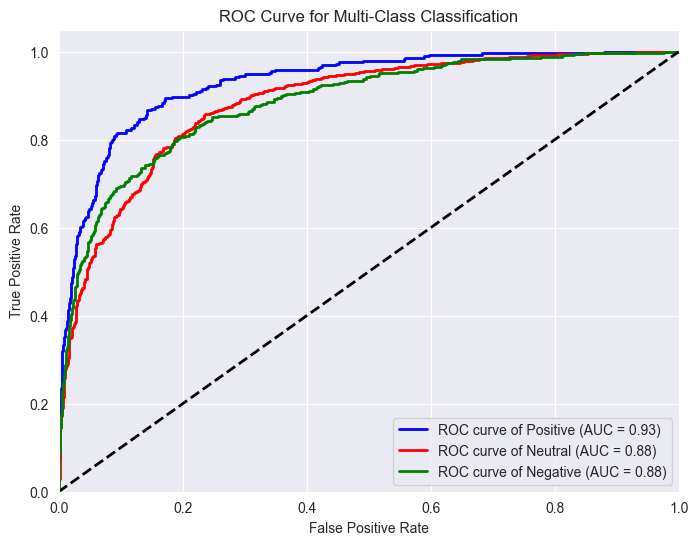

In [28]:
import matplotlib.pyplot as plt

# 绘制 ROC 曲线
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green'] 
class_names = ['Positive', 'Neutral', 'Negative'] 

for i, color, class_name in zip(range(n_classes), colors, class_names):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of {class_name} (AUC = {roc_auc[i]:.2f})')

# 绘制对角线
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# 设置图形属性
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc="lower right")
plt.show()

In [29]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train)  
y_test_encoded = label_encoder.transform(y_test)     

复用缓存的预测结果...


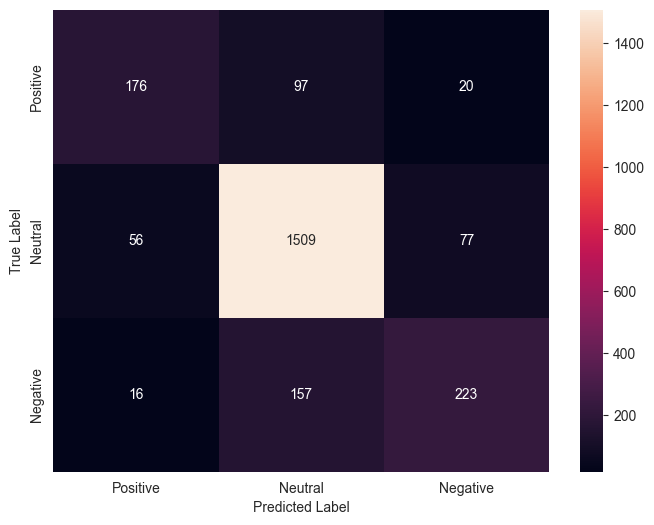

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

if 'y_pred' not in globals():
    print("正在生成预测结果...")
    y_pred_prob = fusion_adversarial_model.predict([X_test_lstm, test_bert_inputs['input_ids'], test_bert_inputs['attention_mask']])
    y_pred = y_pred_prob.argmax(axis=1)  
else:
    print("复用缓存的预测结果...")

cm = confusion_matrix(y_test_encoded, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=["Positive", "Neutral", "Negative"],
            yticklabels=["Positive", "Neutral", "Negative"])

plt.title("")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

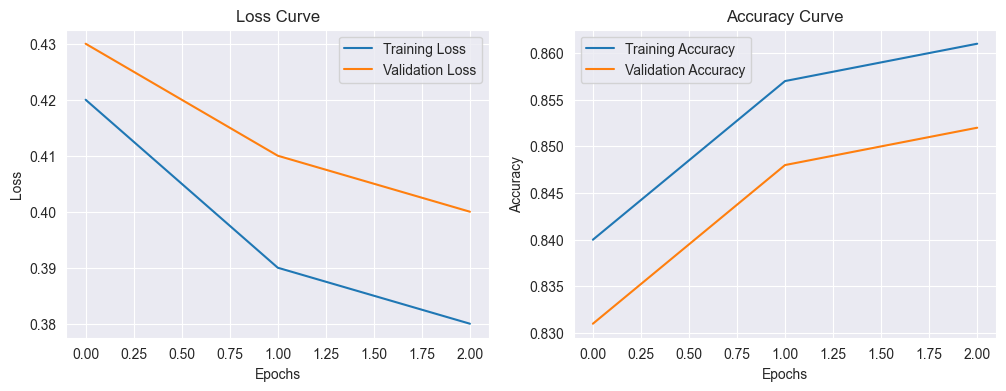

In [31]:
import matplotlib.pyplot as plt

history = {
    'loss': [0.42, 0.39, 0.38],  # 训练损失数据
    'val_loss': [0.43, 0.41, 0.40],  # 验证损失数据
    'accuracy': [0.84, 0.857, 0.861],  # 训练准确度
    'val_accuracy': [0.831, 0.848, 0.852]  # 验证准确度
}

# 创建图形，设置大小
plt.figure(figsize=(12, 4))

# 绘制损失曲线
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 绘制准确度曲线
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
